In [ ]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycopropsz
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# DATA LOADING

In [56]:
dataset_dir = "dataset/"
data = []
labels = []
file_name = []
for sub_folder in os.listdir(dataset_dir):
    sub_folder_files = os.listdir(os.path.join(dataset_dir, sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join(dataset_dir, sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.resize(img, (255,255))
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)
file_name = np.array(file_name)

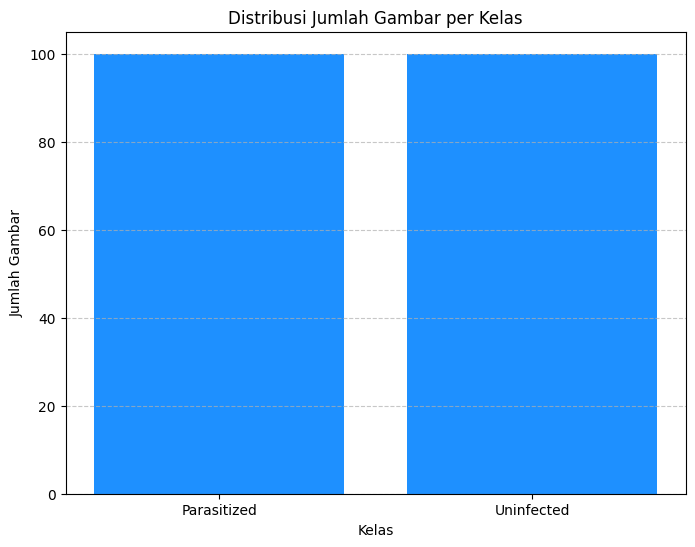

Output: Contoh Sample Data:


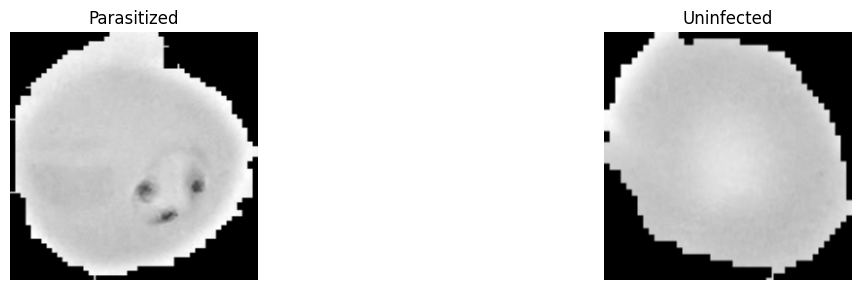

In [57]:
label_counts = Counter(labels)
classes = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color='dodgerblue')
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ======================
# Tampilkan Contoh Gambar
# ======================
print("Output: Contoh Sample Data:")

plt.figure(figsize=(15, 3))
shown_labels = set()
shown = 0

for i in range(len(data)):
    label = labels[i]
    if label in shown_labels:
        continue
    plt.subplot(1, len(classes), shown + 1)
    plt.imshow(data[i], cmap='gray')
    plt.title(f"{label}")
    plt.axis('off')
    shown_labels.add(label)
    shown += 1
    if shown >= len(classes):
        break

plt.tight_layout()
plt.show()

# AUGMENTASI

In [58]:
# def augment_image(img):
#     augmented = []

#     # Flip horizontal
#     flipped = cv.flip(img, 1)
#     augmented.append(flipped)

#     # Rotasi +15 derajat
#     rows, cols = img.shape
#     M_rot1 = cv.getRotationMatrix2D((cols / 2, rows / 2), 15, 1)
#     rotated1 = cv.warpAffine(img, M_rot1, (cols, rows))
#     augmented.append(rotated1)

#     # Rotasi -15 derajat
#     M_rot2 = cv.getRotationMatrix2D((cols / 2, rows / 2), -15, 1)
#     rotated2 = cv.warpAffine(img, M_rot2, (cols, rows))
#     augmented.append(rotated2)

#     # Gaussian Blur
#     blurred = cv.GaussianBlur(img, (5, 5), 0)
#     augmented.append(blurred)

#     # Zoom (crop lalu resize)
#     margin = 10
#     if rows > 2 * margin and cols > 2 * margin:
#         cropped = img[margin:-margin, margin:-margin]
#         zoomed = cv.resize(cropped, (cols, rows))
#         augmented.append(zoomed)

#     return augmented

# # Augmentasi semua data
# data_augmented = []
# labels_augmented = []
# file_name_augmented = []

# for i in range(len(data)):
#     img = data[i]
#     label = labels[i]
#     filename = os.path.splitext(file_name[i])[0]

#     augmented_images = augment_image(img)

#     for j, aug_img in enumerate(augmented_images):
#         data_augmented.append(aug_img)
#         labels_augmented.append(label)
#         file_name_augmented.append(f"{filename}_aug{j}.png")

# # Simpan hasil augmentasi ke folder
# save_dir = "augmented_dataset/"
# os.makedirs(save_dir, exist_ok=True)

# for img, fname in zip(data_augmented, file_name_augmented):
#     save_path = os.path.join(save_dir, fname)
#     cv.imwrite(save_path, img)

# # Gabungkan data asli dan augmentasi untuk pelatihan
# all_data = np.concatenate([data, np.array(data_augmented)], axis=0)
# all_labels = np.concatenate([labels, np.array(labels_augmented)], axis=0)

# print(f"Jumlah data asli      : {len(data)}")
# print(f"Jumlah data augmentasi: {len(data_augmented)}")
# print(f"Total data keseluruhan: {len(all_data)}")

# DATA PREPs

## function support

### Structuring Element

In [59]:
SE = [[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]]

### support

In [60]:
def sorting(arr): #di sort ini harus jd 1 array
    for i in range(len(arr)): 
        swap = i + np.argmin(arr[i:])
        (arr[i], arr[swap]) = (arr[swap], arr[i])
    return arr
def flatArray(arr): #buat jadiin array 1 dimensi
    row, col = arr.shape 
    flat=[]
    for i in range (row):
        for j in range (col):
            flat.append(arr[i][j]) #buat nambahin nilai ke list
    return flat
def fit(window,SE): 
    for i in range(len(SE)):
      for j in range(len(SE)):
        if(SE[i][j]==1 and window[i][j]==0): 
          return 0
    return 1
def getParasite(image):
    ret,parasit = thresholding(image, 118)
    parasit-=255
    return parasit

## Data Preprocessing Function

In [61]:
def thresholding(image, threshold):
    res = np.zeros_like(image, dtype=np.uint8)
    res[image > threshold] = 255
    return res

def median(image,windowHeight,windowWidth):
    pad = np.pad(image,(windowHeight,windowWidth),mode='edge')
    median = np.zeros(image.shape, dtype=np.uint8)
    for i in range(windowHeight,len(pad)-windowHeight):
        for j in range(windowWidth,len(pad)-windowWidth):
            window = flatArray(pad[i-windowHeight:i,j-windowWidth:j])
            window = sorting(window)
            median[i-windowHeight,j-windowWidth] = window[ceil(len(window)/2)]
    return median

def erosi(image,SE):
    erosi = np.zeros(image.shape, dtype=np.uint8)
    row, col = image.shape
    # melakukan perulangan pada window center image
    for i in range(row-len(SE)):
        for j in range(col-len(SE)):
            window = image[i:i+len(SE),j:j+len(SE)]
            # mengambil nilai pada fungsi fit, jika fit maka bernilai 1 jika tidak maka 0
            erosi[i][j] = fit(window,SE)
    return erosi
def segmentation(mainImage, grayImage): #buat maskingnya 
    parasite=getParasite(grayImage)
    erode = erosi(parasite, SE)
    medParasite = median(erode, 4, 4) 
    maskParasite = cv.bitwise_and(mainImage, mainImage, mask=medParasite) #buat maskingnya
    return maskParasite
def convertBinary(image):
    ret, binary = cv.threshold(image,30,255,cv.THRESH_BINARY)
    return binary
def getParasite(image):
    ret,parasit = cv.threshold(image,118,255,cv.THRESH_BINARY)
    parasit-=255
    return parasit

In [62]:
dataPreprocessed = []
output_dir = "preprocessed_images"
os.makedirs(output_dir, exist_ok=True)

for i, imgBGR in enumerate(data): # parameter bisa diubah pakai dataAugmented klo mau
    # 1. Konversi ke RGB
    imgRGB = cv.cvtColor(imgBGR, cv.COLOR_BGR2RGB)

    # 2. Resize ke 255x255
    img = cv.resize(imgRGB, (255, 255))

    # 3. Grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

    # 4. Segmentasi dengan fungsi getParasite
    parasite = getParasite(gray)

    # 5. Erosi
    erode = erosi(parasite, SE)

    # 6. Median filtering (5x5)
    medParasite = median(erode, 4, 4)

    # 7. Masking ke gambar RGB asli
    maskParasite = cv.bitwise_and(img, img, mask=medParasite)

    # 8. Konversi hasil masking ke grayscale
    grayParasite = cv.cvtColor(maskParasite, cv.COLOR_RGB2GRAY)

    # 9. Binarisasi hasil
    binaryParasite = convertBinary(grayParasite)

    # Tambahkan hasil ke list
    dataPreprocessed.append(binaryParasite)

    # Simpan hasil preprocessing ke file
    save_path = os.path.join(output_dir, file_name[i])
    cv.imwrite(save_path, binaryParasite)

print(f"Preprocessing selesai. Hasil disimpan di folder '{output_dir}'.")


KeyboardInterrupt: 

# Feature Extraction

In [63]:

# Fungsi GLCM dengan parameter sudut
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Sudut tidak valid. Harus 0, 45, 90, atau 135 derajat.")
    
    glcm_matrix = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm_matrix

# Fungsi fitur GLCM
def correlation(m): 
    return graycoprops(m, 'correlation')[0, 0]
def dissimilarity(m): 
    return graycoprops(m, 'dissimilarity')[0, 0]
def homogeneity(m): 
    return graycoprops(m, 'homogeneity')[0, 0]
def contrast(m): 
    return graycoprops(m, 'contrast')[0, 0]
def ASM(m): 
    return graycoprops(m, 'ASM')[0, 0]
def energy(m): 
    return graycoprops(m, 'energy')[0, 0]
def entropyGlcm(m): 
    return entropy(m.ravel())

# Folder dataset
folder = 'dataset/'  # Ganti sesuai folder gambar Anda
file_name = []
labels = []
dataPreprocessed = []

# Baca gambar grayscale dari folder
for label in os.listdir(folder):
    label_folder = os.path.join(folder, label)
    for file in os.listdir(label_folder):
        path = os.path.join(label_folder, file)
        img = cv.imread(path, cv.IMREAD_GRAYSCALE)
        img = cv.resize(img, (256, 256))
        dataPreprocessed.append(img)
        file_name.append(file)
        labels.append(label)

# Ekstraksi GLCM
def ekstrak_fitur(dataPreprocessed):
    fitur = {
        'Filename': file_name,
        'Label': labels,
    }

    sudut = [0, 45, 90, 135]
    fungsi_fitur = {
        'Contrast': contrast,
        'Dissimilarity': dissimilarity,
        'Homogeneity': homogeneity,
        'ASM': ASM,
        'Energy': energy,
        'Entropy': entropyGlcm,
        'Correlation': correlation
    }

    for d in sudut:
        glcm_list = [glcm(img, d) for img in dataPreprocessed]
        for nama_fitur, fungsi in fungsi_fitur.items():
            fitur_per_sudut = [fungsi(g) for g in glcm_list]
            fitur[f'{nama_fitur}{d}'] = fitur_per_sudut

    return fitur

# Jalankan ekstraksi dan simpan ke CSV
dataTable = ekstrak_fitur(dataPreprocessed)
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

# Tampilkan hasil
hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
print(hasilEkstrak)

                                         Filename        Label   Contrast0  \
0    C33P1thinF_IMG_20150619_114756a_cell_179.png  Parasitized  147.423928   
1    C33P1thinF_IMG_20150619_114756a_cell_180.png  Parasitized  120.764859   
2    C33P1thinF_IMG_20150619_114756a_cell_181.png  Parasitized  134.017601   
3    C33P1thinF_IMG_20150619_114756a_cell_182.png  Parasitized  149.171783   
4    C33P1thinF_IMG_20150619_115740a_cell_161.png  Parasitized  129.132966   
..                                            ...          ...         ...   
195      C2NThinF_IMG_20150604_114730_cell_72.png   Uninfected  105.569455   
196      C2NThinF_IMG_20150604_114730_cell_98.png   Uninfected  122.188174   
197      C2NThinF_IMG_20150604_114751_cell_38.png   Uninfected  105.101241   
198      C2NThinF_IMG_20150604_114751_cell_69.png   Uninfected   94.017739   
199      C2NThinF_IMG_20150604_114751_cell_92.png   Uninfected   99.715548   

     Dissimilarity0  Homogeneity0      ASM0   Energy0  Entropy0

# Feature Selection

In [64]:
# 1. Baca data hasil ekstraksi
df = pd.read_csv('hasil_ekstraksi_1.csv')

# 2. Pisahkan fitur dan label
fitur_asli = df.drop(columns=['Filename', 'Label'])  # hanya fitur numerik
label = df['Label']  # simpan label untuk nanti digunakan

# 3. Normalisasi fitur
scaler = StandardScaler()
fitur_normal = scaler.fit_transform(fitur_asli)

# 4. Terapkan PCA
# Anda bisa tentukan jumlah komponen PCA, misalnya 10
# Atau menggunakan variansi kumulatif untuk threshold tertentu, misalnya 95%
pca = PCA(n_components=0.95)  # simpan komponen yang menjelaskan 95% variansi
fitur_pca = pca.fit_transform(fitur_normal)

# 5. Gabungkan kembali dengan label
df_pca = pd.DataFrame(fitur_pca, columns=[f'PC{i+1}' for i in range(fitur_pca.shape[1])])
df_pca['Label'] = label

# 6. Simpan ke file CSV
df_pca.to_csv('fitur_pca.csv', index=False)

# 7. Tampilkan hasil
print(df_pca.head())

        PC1       PC2       PC3       PC4        Label
0  6.228897  6.868431  0.498468 -0.124014  Parasitized
1  3.965044  4.477952  0.514773 -1.079273  Parasitized
2  8.447399  4.918843  0.287094  0.000092  Parasitized
3  2.429218  6.135115 -0.339894  0.540344  Parasitized
4  4.262728  2.933662 -0.502038  1.474789  Parasitized


# Splitting Data

In [65]:
# 1. Baca data hasil PCA
df_pca = pd.read_csv('fitur_pca.csv')

# 2. Pisahkan fitur dan label
X = df_pca.drop(columns=['Label'])  # fitur (PC1, PC2, ...)
y = df_pca['Label']                 # target label

# 3. Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Tampilkan shape hasil split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (160, 4)
X_test shape: (40, 4)
y_train shape: (160,)
y_test shape: (40,)


In [66]:
# Hitung mean dan std per fitur dari data training
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)

# Normalisasi data train dan test dengan Z-score
X_train = (X_train - mean_train) / std_train
X_test = (X_test - mean_train) / std_train


# Modeling

In [67]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)



## Random Forest

In [68]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

 Parasitized       0.97      0.97      0.97        79
  Uninfected       0.98      0.98      0.98        81

    accuracy                           0.97       160
   macro avg       0.97      0.97      0.97       160
weighted avg       0.97      0.97      0.97       160

[[77  2]
 [ 2 79]]
Accuracy: 0.975

------Testing Set------
              precision    recall  f1-score   support

 Parasitized       0.90      0.90      0.90        21
  Uninfected       0.89      0.89      0.89        19

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

[[19  2]
 [ 2 17]]
Accuracy: 0.9


## SVM

In [69]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

 Parasitized       0.95      0.91      0.93        79
  Uninfected       0.92      0.95      0.93        81

    accuracy                           0.93       160
   macro avg       0.93      0.93      0.93       160
weighted avg       0.93      0.93      0.93       160

[[72  7]
 [ 4 77]]
Accuracy: 0.93125

------Testing Set------
              precision    recall  f1-score   support

 Parasitized       0.90      0.90      0.90        21
  Uninfected       0.89      0.89      0.89        19

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

[[19  2]
 [ 2 17]]
Accuracy: 0.9


## KNN

In [70]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

 Parasitized       0.96      0.92      0.94        79
  Uninfected       0.93      0.96      0.95        81

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

[[73  6]
 [ 3 78]]
Accuracy: 0.94375

------Testing Set------
              precision    recall  f1-score   support

 Parasitized       0.94      0.71      0.81        21
  Uninfected       0.75      0.95      0.84        19

    accuracy                           0.82        40
   macro avg       0.84      0.83      0.82        40
weighted avg       0.85      0.82      0.82        40

[[15  6]
 [ 1 18]]
Accuracy: 0.825


# Evaluasi

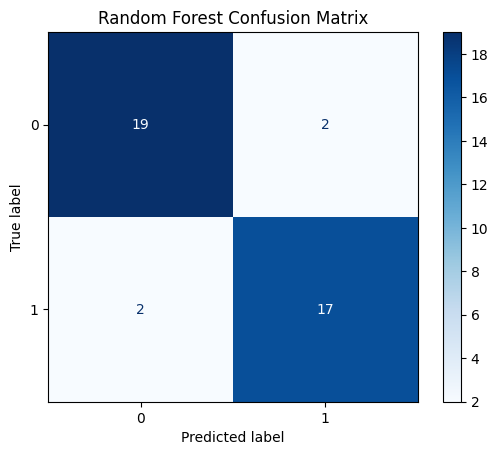

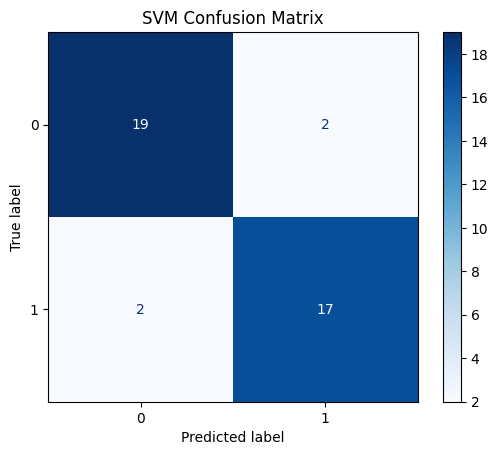

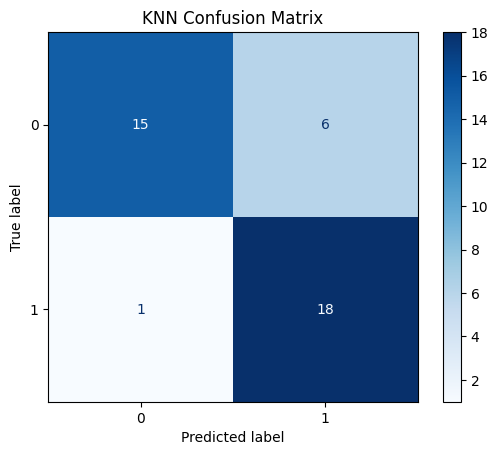

In [71]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")